In [153]:
import os
import sys
import torch 
import numpy as np
import pandas as pd

import mlflow

In [154]:
path_to_package = os.path.abspath(os.path.join('..'))
if path_to_package not in sys.path:
    sys.path.append(path_to_package)
    
from src.utils.data_model_region import Region

In [192]:
# Global Constants
# Dataset
DATA_DIR_PATH = "./../data"
DATASET_PATH = f"{DATA_DIR_PATH}/PRSA2017_Data_20130301-20170228"
DATSET_PREPROCESSED_PATH = f"{DATA_DIR_PATH}/preprocessed"

# Model 
IS_HOUR = False
RANDOM_STATE = 1
PAST_WINDOW = 7
if IS_HOUR:
    PAST_WINDOW *= 24
FUTURE_WINDOW = 30
if IS_HOUR:
    FUTURE_WINDOW *= 24
BATCH_SIZE = 2048*16
ROLLING_WINDOW = 90
if IS_HOUR:
    ROLLING_WINDOW *= 24


DATE_COLUMNS = ['year','month','day','hour'] if IS_HOUR else ['year','month','day']
POLUTION_FEATURES = ["PM2.5","PM10","SO2","NO2","CO","O3"]
MODEL_INPUT_FEATURES = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']




def get_preprocessed_dataset_path(region:Region, base_path:str=DATSET_PREPROCESSED_PATH)->str|None:
    """Get path to pre-processed dataset

    Args:
        region (Region): Specifies the region of the dataset
        base_path (str, optional): root dir of the dataset. Defaults to DATASET_PATH.

    Raises:
        ValueError: incorrect region provided

    Returns:
        str|None: returns the datset file path for the region or raises error
    """
    if type(region) == Region:
        return f"{base_path}/{region.value}.csv"
    else:
        raise ValueError("Unkown REGION name!!!")

In [193]:
regions_df = {}

for region in Region:
    # read datset
    regions_df[region] = pd.read_csv(get_preprocessed_dataset_path(region=region), index_col=None)
    # generate date
    regions_df[region]['date'] = pd.to_datetime(regions_df[region][DATE_COLUMNS])
    regions_df[region].drop(DATE_COLUMNS, axis=1, inplace=True)
    
    regions_df[region].drop('hour', axis=1, inplace=True)
    # group by daily and average
    regions_df[region] = regions_df[region].groupby('date').mean()
    
    # # set datetime index 
    # regions_df[region] = regions_df[region].set_index('date')

    # cal roll mean
    regions_df[region] = regions_df[region].rolling(ROLLING_WINDOW).mean().dropna()

    # # create diff
    # regions_df[region] = regions_df[region].diff(1).dropna()

    #standardise
    regions_df[region] = (regions_df[region]-regions_df[region].mean())/regions_df[region].std()
    
    # add week info
    regions_df[region]['week'] = regions_df[region].index.to_series().dt.isocalendar().week
    regions_df[region]['month'] = regions_df[region].index.to_series().dt.month

del region

In [194]:
regions_df[Region.AOTIZHONGXIN]

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,N,S,E,W,week,month
date,,,,,,,,,,,,,,,,,
2013-05-29,0.273523,0.992717,1.432985,0.336733,-0.300970,0.012788,-0.120301,-0.408371,-0.288071,-0.782687,0.860445,-0.467595,0.992583,-1.938188,1.280947,22,5
2013-05-30,0.305986,1.058998,1.441451,0.390356,-0.296491,0.025840,-0.092664,-0.444464,-0.260898,-0.782687,0.833748,-0.552336,1.076097,-1.945893,1.339451,22,5
2013-05-31,0.349205,1.118949,1.437355,0.377774,-0.296328,0.063424,-0.064875,-0.485315,-0.229679,-0.782687,0.843016,-0.612153,1.154391,-2.046065,1.448100,22,5
2013-06-01,0.344503,1.120215,1.388623,0.359622,-0.320969,0.085981,-0.042419,-0.504009,-0.207791,-0.782687,0.831120,-0.642062,1.185709,-1.999832,1.414669,22,6
2013-06-02,0.433025,1.191946,1.381468,0.378872,-0.298653,0.093070,-0.028322,-0.529286,-0.179997,-0.782687,0.788793,-0.647046,1.175270,-1.891955,1.364524,22,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-24,1.686160,0.638080,0.292154,1.214119,1.643806,-0.689243,-1.450108,1.522517,-1.383698,-0.992433,0.222596,1.081742,-0.956724,0.865679,-0.303588,8,2
2017-02-25,1.653500,0.609241,0.291023,1.200249,1.626593,-0.676081,-1.444854,1.516082,-1.383430,-0.992433,0.224256,1.071773,-0.946284,0.804035,-0.236727,8,2
2017-02-26,1.632862,0.585209,0.284038,1.179975,1.598817,-0.660122,-1.437328,1.505272,-1.383068,-0.992433,0.247495,1.066788,-0.925406,0.750096,-0.194939,8,2


In [195]:
import copy
feature = "PM2.5"
feature_df = regions_df[Region.AOTIZHONGXIN][[feature]]
window = PAST_WINDOW+FUTURE_WINDOW
shift = window
dfs = []
for i in range(shift):
    dfs.append((feature_df[feature].shift(i+1)))

feature_df = pd.concat(dfs, axis=1).dropna()

feature_df.columns=[f"shift_{shift-index-1}" for index in range(shift)]
feature_df

,shift_36,shift_35,shift_34,shift_33,shift_32,shift_31,shift_30,shift_29,shift_28,shift_27,...,shift_9,shift_8,shift_7,shift_6,shift_5,shift_4,shift_3,shift_2,shift_1,shift_0
date,,,,,,,,,,,,,,,,,,,,,
2013-07-05,0.084735,0.107034,0.133895,0.208479,0.157574,0.072009,0.120943,-0.040192,-0.037939,-0.121276,...,0.226650,0.185987,0.249957,0.344954,0.412471,0.433025,0.344503,0.349205,0.305986,0.273523
2013-07-06,0.090676,0.084735,0.107034,0.133895,0.208479,0.157574,0.072009,0.120943,-0.040192,-0.037939,...,0.318297,0.226650,0.185987,0.249957,0.344954,0.412471,0.433025,0.344503,0.349205,0.305986
2013-07-07,0.075725,0.090676,0.084735,0.107034,0.133895,0.208479,0.157574,0.072009,0.120943,-0.040192,...,0.266997,0.318297,0.226650,0.185987,0.249957,0.344954,0.412471,0.433025,0.344503,0.349205
2013-07-08,0.117931,0.075725,0.090676,0.084735,0.107034,0.133895,0.208479,0.157574,0.072009,0.120943,...,0.199874,0.266997,0.318297,0.226650,0.185987,0.249957,0.344954,0.412471,0.433025,0.344503
2013-07-09,0.176466,0.117931,0.075725,0.090676,0.084735,0.107034,0.133895,0.208479,0.157574,0.072009,...,0.231239,0.199874,0.266997,0.318297,0.226650,0.185987,0.249957,0.344954,0.412471,0.433025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-24,1.859402,1.960031,1.952139,1.920123,1.918123,1.850915,1.829996,1.902581,1.951009,1.873975,...,1.919757,1.894220,1.787848,1.689964,1.663272,1.710658,1.741122,1.740813,1.736815,1.735435
2017-02-25,1.686160,1.859402,1.960031,1.952139,1.920123,1.918123,1.850915,1.829996,1.902581,1.951009,...,2.143510,1.919757,1.894220,1.787848,1.689964,1.663272,1.710658,1.741122,1.740813,1.736815
2017-02-26,1.653500,1.686160,1.859402,1.960031,1.952139,1.920123,1.918123,1.850915,1.829996,1.902581,...,2.166739,2.143510,1.919757,1.894220,1.787848,1.689964,1.663272,1.710658,1.741122,1.740813


In [196]:
feature_df.corr().style.background_gradient(cmap='coolwarm')

,shift_36,shift_35,shift_34,shift_33,shift_32,shift_31,shift_30,shift_29,shift_28,shift_27,shift_26,shift_25,shift_24,shift_23,shift_22,shift_21,shift_20,shift_19,shift_18,shift_17,shift_16,shift_15,shift_14,shift_13,shift_12,shift_11,shift_10,shift_9,shift_8,shift_7,shift_6,shift_5,shift_4,shift_3,shift_2,shift_1,shift_0
shift_36,1.000000,0.997859,0.993248,0.987746,0.981981,0.976186,0.970323,0.964395,0.958471,0.952371,0.945973,0.939286,0.932280,0.925031,0.917481,0.909577,0.901265,0.892634,0.883840,0.874968,0.866016,0.856983,0.847688,0.838051,0.828090,0.817622,0.806602,0.795265,0.783631,0.771555,0.758971,0.745837,0.732302,0.718464,0.704383,0.690230,0.676074
shift_35,0.997859,1.000000,0.997855,0.993231,0.987723,0.981966,0.976179,0.970294,0.964347,0.958399,0.952271,0.945865,0.939177,0.932162,0.924884,0.917315,0.909396,0.901066,0.892417,0.883600,0.874717,0.865750,0.856698,0.847380,0.837725,0.827721,0.817222,0.806191,0.794839,0.783172,0.771051,0.758418,0.745242,0.731691,0.717834,0.703749,0.689575
shift_34,0.993248,0.997855,1.000000,0.997849,0.993219,0.987714,0.981965,0.976153,0.970249,0.964276,0.958301,0.952167,0.945760,0.939062,0.932020,0.924724,0.917143,0.909206,0.900857,0.892183,0.883358,0.874462,0.865476,0.856402,0.847065,0.837370,0.827337,0.816825,0.805779,0.794395,0.782686,0.770518,0.757845,0.744652,0.731083,0.717220,0.703114
shift_33,0.987746,0.993231,0.997849,1.000000,0.997844,0.993213,0.987719,0.981936,0.976105,0.970170,0.964170,0.958192,0.952059,0.945641,0.938917,0.931859,0.924555,0.916957,0.909003,0.900625,0.891949,0.883115,0.874204,0.865197,0.856102,0.846731,0.837010,0.826961,0.816433,0.805359,0.793939,0.782188,0.769981,0.757287,0.744077,0.730500,0.716615
shift_32,0.981981,0.987723,0.993219,0.997844,1.000000,0.997848,0.993225,0.987703,0.981901,0.976043,0.970082,0.964077,0.958098,0.951954,0.945512,0.938772,0.931704,0.924384,0.916768,0.908788,0.900403,0.891714,0.882861,0.873927,0.864901,0.855771,0.846371,0.836637,0.826572,0.816014,0.804901,0.793435,0.781647,0.769425,0.756714,0.743499,0.729901
shift_31,0.976186,0.981966,0.987714,0.993213,0.997848,1.000000,0.997845,0.993206,0.987668,0.981842,0.975965,0.969997,0.963977,0.957981,0.951821,0.945366,0.938616,0.931535,0.924192,0.916547,0.908545,0.900131,0.891410,0.882528,0.873571,0.864519,0.855354,0.845931,0.836169,0.826065,0.815459,0.804295,0.792815,0.781018,0.768789,0.756086,0.742852
shift_30,0.970323,0.976179,0.981965,0.987719,0.993225,0.997845,1.000000,0.997830,0.993178,0.987612,0.981771,0.975889,0.969902,0.963860,0.957852,0.951683,0.945223,0.938462,0.931354,0.923975,0.916310,0.908277,0.899830,0.891079,0.882170,0.873197,0.864109,0.854910,0.845450,0.835648,0.825498,0.814846,0.803682,0.792190,0.780392,0.768174,0.755452
shift_29,0.964395,0.970294,0.976153,0.981936,0.987703,0.993206,0.997830,1.000000,0.997824,0.993157,0.987578,0.981725,0.975822,0.969815,0.963759,0.957740,0.951558,0.945087,0.938301,0.931167,0.923756,0.916050,0.907977,0.899498,0.890725,0.881789,0.872774,0.863666,0.854436,0.844931,0.835072,0.824869,0.814210,0.803045,0.791551,0.779769,0.767537
shift_28,0.958471,0.964347,0.970249,0.976105,0.981901,0.987668,0.993178,0.997824,1.000000,0.997815,0.993136,0.987546,0.981674,0.975753,0.969731,0.963664,0.957631,0.951438,0.944944,0.938134,0.930971,0.923523,0.915781,0.907678,0.899178,0.890374,0.881398,0.872367,0.863233,0.853961,0.844400,0.834489,0.824273,0.813614,0.802445,0.790964,0.779168
shift_27,0.952371,0.958399,0.964276,0.970170,0.976043,0.981842,0.987612,0.993157,0.997815,1.000000,0.997811,0.993120,0.987510,0.981622,0.975685,0.969650,0.963564,0.957520,0.951305,0.944793,0.937948,0.930744,0.923257,0.915484,0.907364,0.898829,0.889982,0.880996,0.871944,0.862764,0.853431,0.843814,0.833885,0.823676,0.813013,0.801859,0.790368


In [197]:

feature = "PM2.5"
x_df = regions_df[Region.AOTIZHONGXIN][MODEL_INPUT_FEATURES].shift(FUTURE_WINDOW)
y_df = regions_df[Region.AOTIZHONGXIN][[feature]]
dataset_df = pd.concat([y_df,x_df],axis=1).dropna()
dataset_df.columns = ['target'] + MODEL_INPUT_FEATURES
print(dataset_df.head())
dataset_df.corr().style.background_gradient(cmap='coolwarm')

              target     PM2.5      PM10       SO2       NO2        CO   
date                                                                     
2013-06-28  0.120943  0.273523  0.992717  1.432985  0.336733 -0.300970  \
2013-06-29  0.072009  0.305986  1.058998  1.441451  0.390356 -0.296491   
2013-06-30  0.157574  0.349205  1.118949  1.437355  0.377774 -0.296328   
2013-07-01  0.208479  0.344503  1.120215  1.388623  0.359622 -0.320969   
2013-07-02  0.133895  0.433025  1.191946  1.381468  0.378872 -0.298653   

                  O3      TEMP      PRES      DEWP      RAIN      WSPM  
date                                                                    
2013-06-28  0.012788 -0.120301 -0.408371 -0.288071 -0.782687  0.860445  
2013-06-29  0.025840 -0.092664 -0.444464 -0.260898 -0.782687  0.833748  
2013-06-30  0.063424 -0.064875 -0.485315 -0.229679 -0.782687  0.843016  
2013-07-01  0.085981 -0.042419 -0.504009 -0.207791 -0.782687  0.831120  
2013-07-02  0.093070 -0.028322 -0.529286 -0

,target,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
target,1.000000,0.759373,0.464094,0.401641,0.783945,0.658024,-0.772697,-0.546415,0.585696,-0.374351,-0.485099,-0.339641
PM2.5,0.759373,1.000000,0.793355,0.566862,0.819916,0.801950,-0.767470,-0.685051,0.646836,-0.557243,-0.622317,-0.154223
PM10,0.464094,0.793355,1.000000,0.652327,0.640822,0.534957,-0.600110,-0.629187,0.530235,-0.632164,-0.736631,0.162847
SO2,0.401641,0.566862,0.652327,1.000000,0.372014,0.551561,-0.621168,-0.717396,0.564053,-0.726719,-0.671029,0.186072
NO2,0.783945,0.819916,0.640822,0.372014,1.000000,0.681986,-0.793073,-0.534078,0.544876,-0.346678,-0.472946,-0.424784
CO,0.658024,0.801950,0.534957,0.551561,0.681986,1.000000,-0.803914,-0.887523,0.881556,-0.769146,-0.663391,0.120221
O3,-0.772697,-0.767470,-0.600110,-0.621168,-0.793073,-0.803914,1.000000,0.845328,-0.854193,0.711535,0.748135,0.181252
TEMP,-0.546415,-0.685051,-0.629187,-0.717396,-0.534078,-0.887523,0.845328,1.000000,-0.964301,0.965332,0.860268,-0.308087
PRES,0.585696,0.646836,0.530235,0.564053,0.544876,0.881556,-0.854193,-0.964301,1.000000,-0.905685,-0.820084,0.257771
DEWP,-0.374351,-0.557243,-0.632164,-0.726719,-0.346678,-0.769146,0.711535,0.965332,-0.905685,1.000000,0.877664,-0.503597


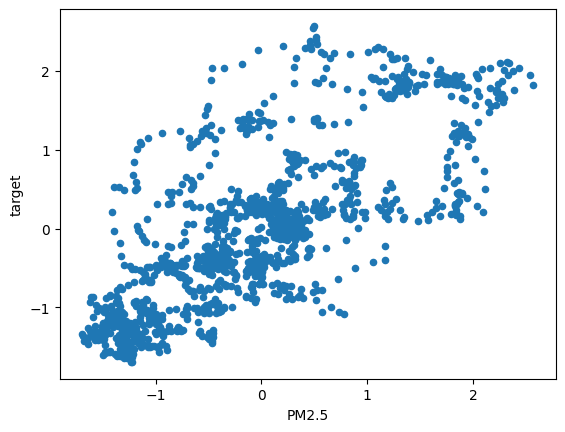

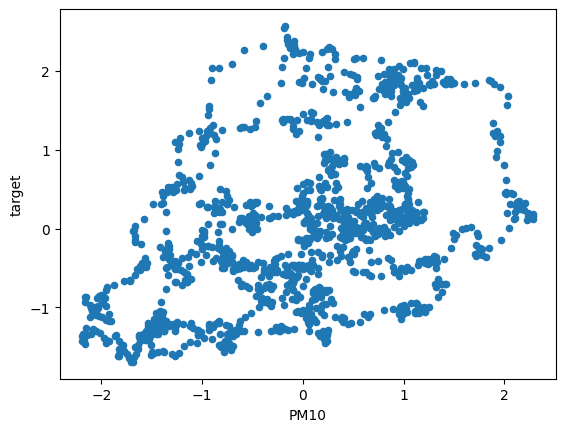

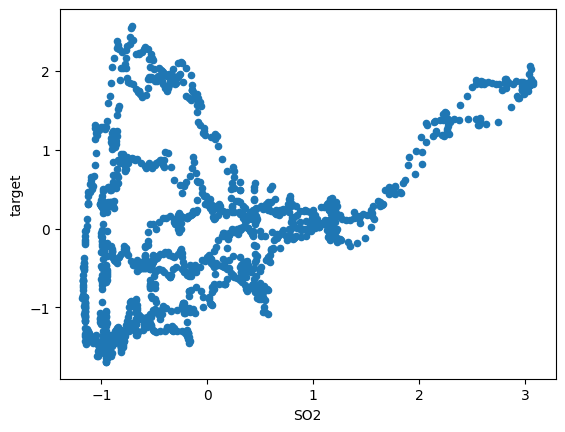

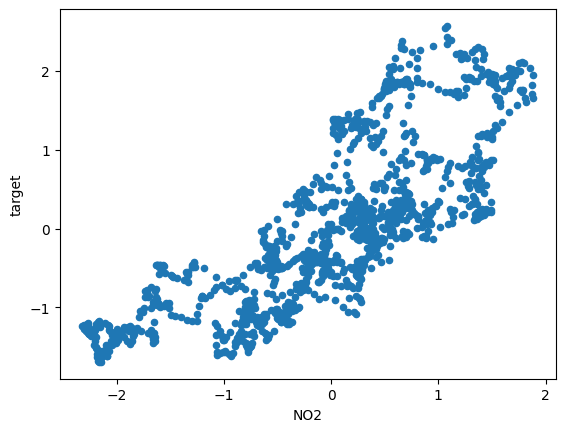

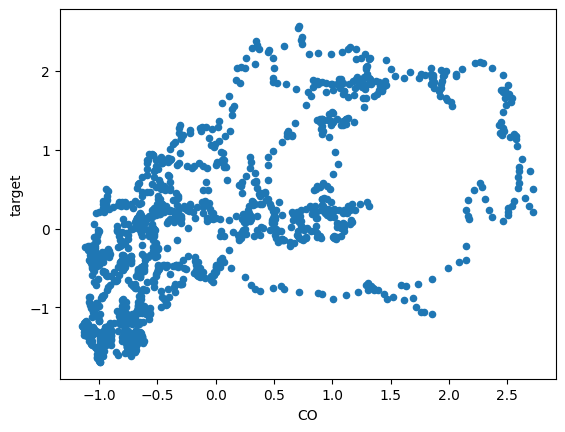

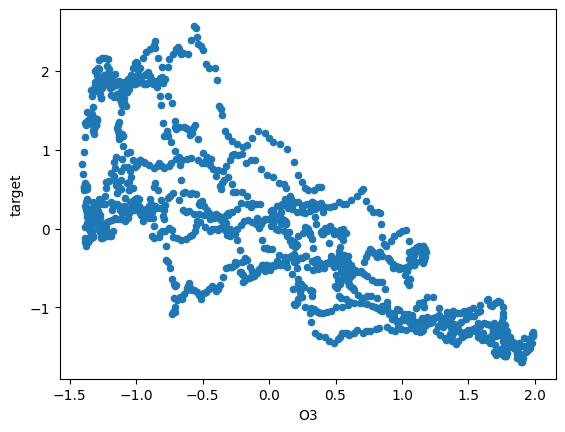

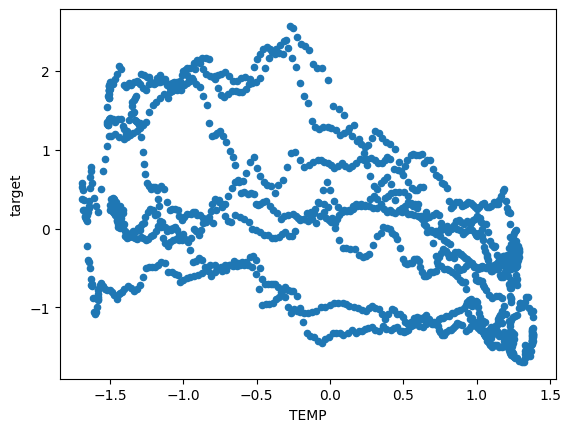

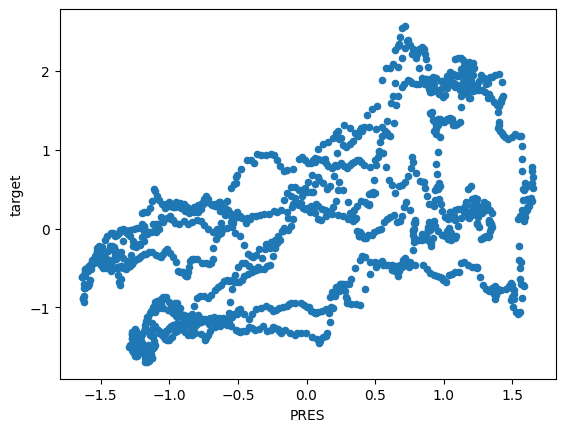

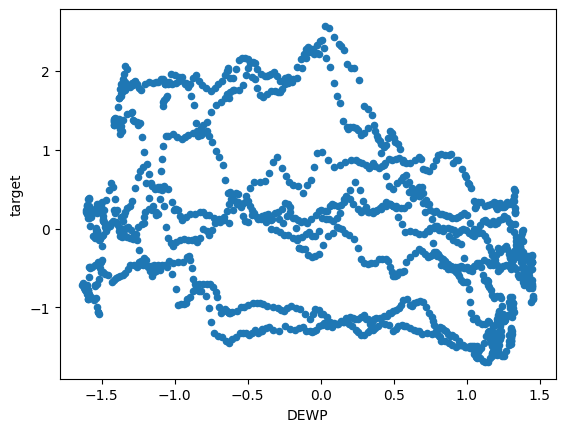

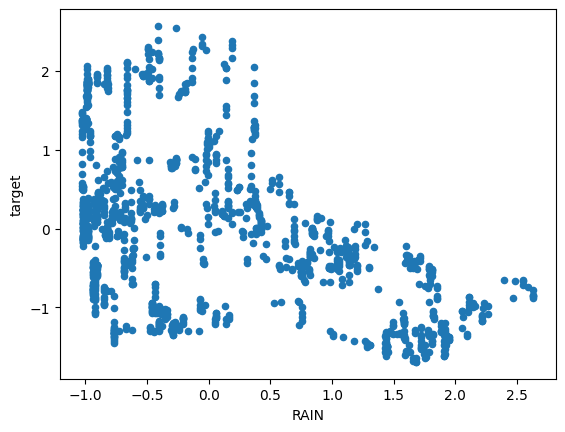

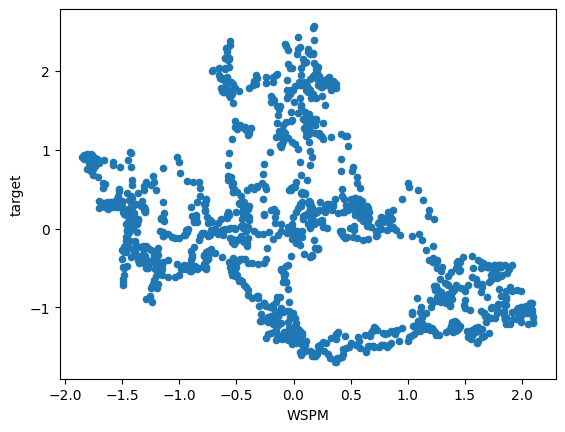

In [198]:
for feature in MODEL_INPUT_FEATURES:
    dataset_df[['target',feature]].plot(
        kind='scatter',
        y='target',
        x=feature)

In [199]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [200]:
# def train_test_split(x_df:pd.DataFrame, y_df:pd.DataFrame, split_date:str='2016-03-01 00:00:00'):
#     train_len = len(x_df[x_df.index < split_date]) 
#     X_train = x_df[:train_len]
#     X_test = x_df[train_len:]
#     y_train = y_df[:train_len]
#     y_test = y_df[train_len:]
#     del train_len
#     return X_train, X_test, y_train, y_test 

In [201]:
# Auto log all MLflow entities
mlflow.sklearn.autolog()
mlflow.set_tracking_uri("http://localhost:5001")
mlflow.set_experiment("AQL-LR-MM-RA")

regression_model = {}
X_train = {}
X_test = {}
y_train = {}
y_test = {}

# build datset
x_df = regions_df[Region.AOTIZHONGXIN][POLUTION_FEATURES].shift(FUTURE_WINDOW)
y_df = regions_df[Region.AOTIZHONGXIN][POLUTION_FEATURES]
dataset_df = pd.concat([y_df,x_df],axis=1).dropna()
target_col = [f'{feature}_target' for feature in POLUTION_FEATURES]
dataset_df.columns = target_col + POLUTION_FEATURES

# test train split
# X_train, X_test, y_train, y_test = train_test_split(dataset_df[MODEL_INPUT_FEATURES], dataset_df[['target']], split_date='2017-01-01 00:00:00')
X_train, X_test, y_train, y_test = train_test_split(dataset_df[POLUTION_FEATURES], dataset_df[target_col], test_size=0.4)

for feature in POLUTION_FEATURES:
    # build model
    regression_model[feature] = LinearRegression()

    with mlflow.start_run() as run:
        regression_model[feature].fit(X_train, y_train[[f"{feature}_target"]])

    # make predictions
    y_predicted = regression_model[feature].predict(X_test)

    # evaluate
    mae = metrics.mean_absolute_error(y_test[[f"{feature}_target"]], y_predicted)
    rmse = metrics.mean_squared_error(y_test[[f"{feature}_target"]], y_predicted, squared=False)
    r2 = metrics.r2_score(y_test[[f"{feature}_target"]], y_predicted)

    # store the results
    evaluation = [feature, mae, rmse, r2]
    print(evaluation)

['PM2.5', 0.35975151200188804, 0.47445008350124784, 0.7698903811691278]
['PM10', 0.3536313078525028, 0.4392241561300552, 0.8093728824762139]
['SO2', 0.21495341859020078, 0.2608265226282988, 0.9234683057500663]
['NO2', 0.26897796201713475, 0.3245633100533939, 0.8993968559463424]
['CO', 0.2585305244508655, 0.34329560449599866, 0.8856513735079289]
['O3', 0.14448689123519104, 0.1816729177547803, 0.9672992024154634]


<Axes: xlabel='pred', ylabel='target'>

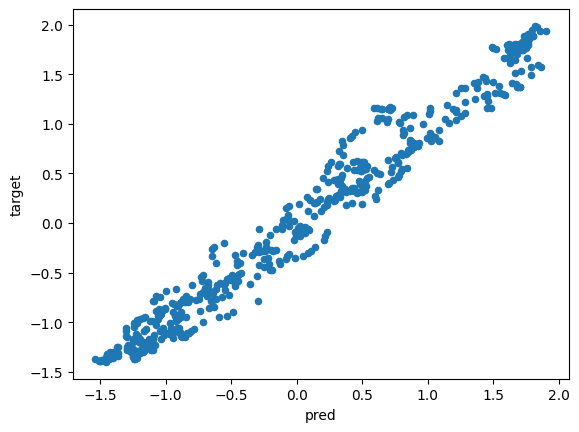

In [203]:
pd.DataFrame({
    'pred': y_predicted.flatten(),
    'target': y_test[f'O3_target'].to_list()
}).plot(kind='scatter',x='pred',y='target')

In [209]:
predict_df = {}

for feature in POLUTION_FEATURES: 
    predict_df[f"pred_{feature}"] = regression_model[feature].predict(dataset_df[POLUTION_FEATURES][10:10+FUTURE_WINDOW]).flatten().tolist()
    
predict_df = pd.DataFrame(
    data=predict_df,
    # index=dataset_df.index[:FUTURE_WINDOW]
    )

for batch in range(int((len(dataset_df)/FUTURE_WINDOW)-1)):
    new_predicts = []
    for index in range(FUTURE_WINDOW):
        predictions = []
        for feature in POLUTION_FEATURES:
            prediction = regression_model[feature].predict([predict_df.iloc[batch*FUTURE_WINDOW+index].to_list()])[0][0]
            predictions.append(prediction)
        new_predicts.append(predictions)
    new_predicts = pd.DataFrame(new_predicts,columns=[f"pred_{feature}" for feature in POLUTION_FEATURES])
    predict_df = pd.concat([predict_df,new_predicts],axis=0,ignore_index=True)

/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/sit

<Axes: >

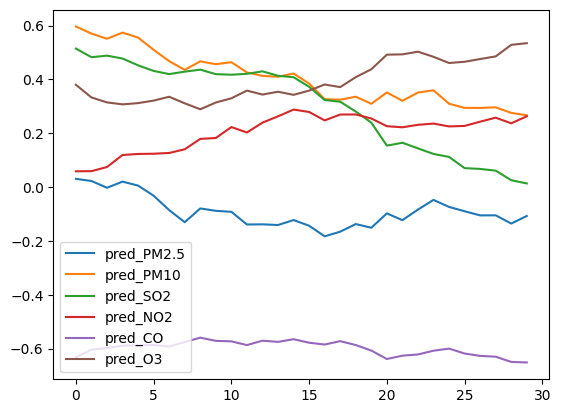

In [210]:
predict_df[0:30][[f"pred_{feature}" for feature in POLUTION_FEATURES]].plot()

<Axes: >

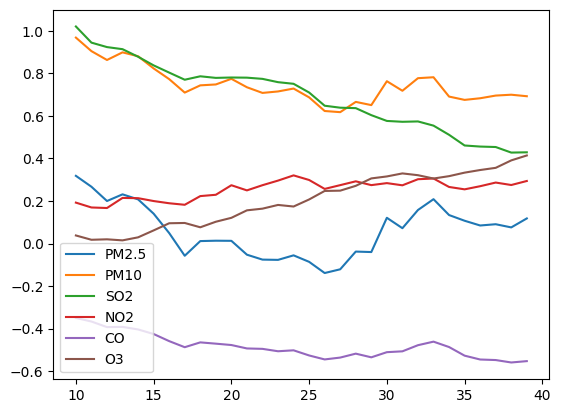

In [211]:
dataset_df.reset_index()[POLUTION_FEATURES][10:40].plot()